In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import datetime
import json

In [4]:
benchmarks = pd.read_csv('input/benchmarks.csv')
backup = {e['Model']: {
    'power': float(e['Power (Watts)']),
} for e in benchmarks.to_dict(orient='records')}

reference = pd.read_csv('input/reference.csv')
reference = {e['Model']: {
    'power': float(e['Power (Watts)']),
    'release': pd.to_datetime(e['Release']).date()
} for e in reference.to_dict(orient='records')}

In [5]:
# compute median power from different benchmarks
# for use when we have a hashrate but no power for a benchmark
power_estimates = defaultdict(list)
for model, ref_model, hashrate, power, source in benchmarks.values:
    if power != power:
        continue
    if ref_model != ref_model:
        continue
    power_estimates[ref_model].append(power)
    
median_power = {e:np.median(p) for e,p in power_estimates.items()}

In [6]:
stats_by_source = defaultdict(list)
stats_by_group = defaultdict(list)
stats_by_model = defaultdict(list)

# this parameter was found by analyzing minermonitoring.com benchmarks 
def nominal_to_true_power(nominal_power):
    return nominal_power * 0.738545503572799

for model, ref_model, hashrate, power, source in benchmarks.values:
    # if we don't have a reference model for this, ignore it
    if ref_model not in reference:
        continue
    # if we don't have a power estimate with this benchmark
    if power != power:
        # if we have power from some other benchmark, use that
        if ref_model in median_power:
            power = median_power[ref_model]
        else:
            # use the nominal power for the reference model
            nominal_power = reference[ref_model]['power']
            # if there is no nominal power, skip this benchmark
            if nominal_power != nominal_power:
                continue
            # convert the nominal power to true power
            power = nominal_to_true_power(nominal_power)
    efficiency = hashrate / power
    
    stats_by_source[source].append((ref_model, hashrate, efficiency))
    stats_by_model[ref_model].append((hashrate, efficiency))
    
    group = 'Benchmarking site'
    if source == 'nvidia.com':
        group = 'Nvidia'
    if source == 'minermonitoring.com':
        group = 'MinerMonitoring'
    if source in ('sparkpool.com', 'nicehash.com', 'viperatech.com'):
        group = 'Mining service'
    stats_by_group[group].append((ref_model, hashrate, efficiency))

In [7]:
typical_hashrate_and_efficiency = {}
for model, stats in stats_by_model.items():
    hashrates, efficiencies = zip(*stats)
    typical_hashrate_and_efficiency[model] = {
        'hashrate': np.median(hashrates),
        'efficiency': np.median(efficiencies)
    }
    
with open('output/typical-hashrate-and-efficiency.json', 'w') as f:
    json.dump(dict(typical_hashrate_and_efficiency), f)

In [8]:
def clean_label(label):
    return label\
        .replace('GeForce ', '')\
        .replace('Radeon ', '')\
        .replace('Innosilicon ', '')\
        .replace('Nvidia ','')\
        .replace('GTX ', '')\
        .replace('RTX ', '')\
        .replace('CMP ', '')\
        .replace(' ETHMiner', '')\
        .replace(' ETHMaster', '')\
        .replace(' 2GB', '')\
        .replace(' 6GB', '')\
        .replace(' 8GB', '')\
        .replace(' Super', 'S')\
        .replace('RX ', 'RX')

def date_to_timestamp(e):
    return datetime.datetime.timestamp(datetime.datetime(e.year, e.month, e.day))

def timestamp_to_date(e):
    return datetime.datetime.fromtimestamp(e).date()

In [9]:
top_models = """\
a10
170
3070
1660
3060
3080
p106
2060
1060
1070
1660
2060
580
570
5700
470
6700
580
470
6600 XT
5600""".splitlines()

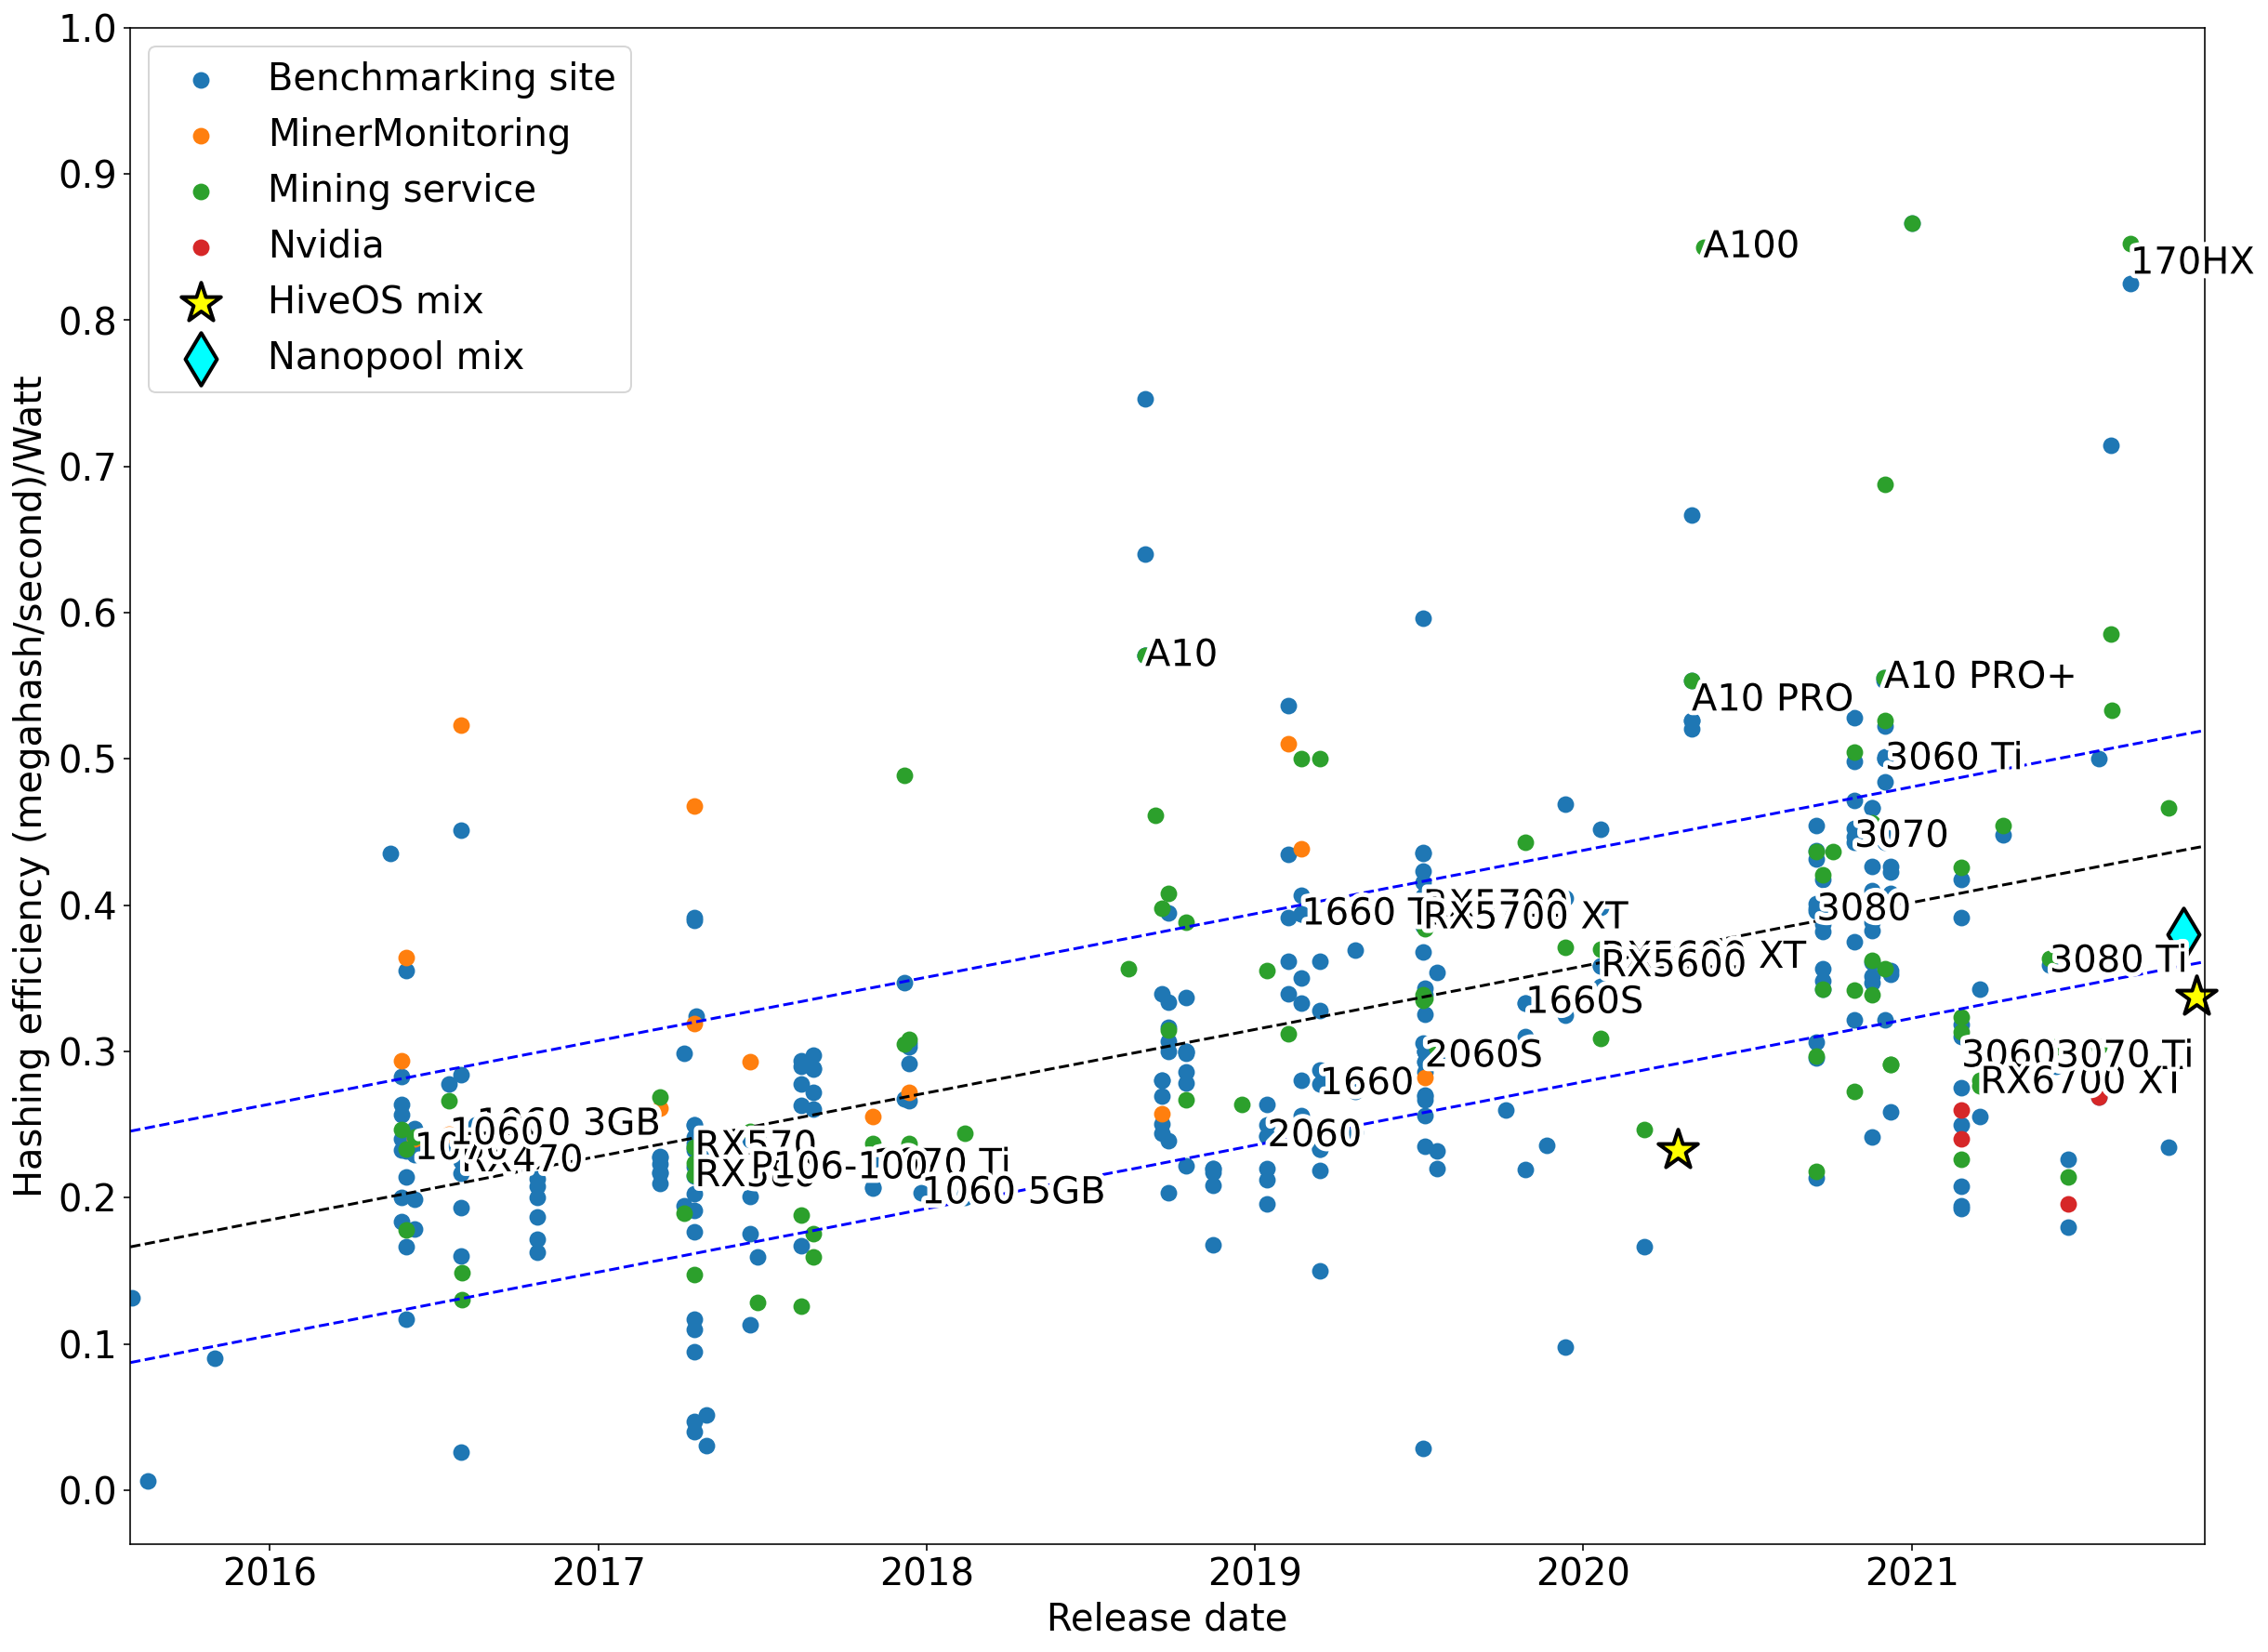

z = (1.3744496623898123e-09, -1.81046377784513)
mae = 0.07911432750414212
efficiency_mae=\eff{0.08}


In [19]:
# trendline_mode = 'per_gpu'
trendline_mode = 'per_benchmark'
xs = []
ys = []

plt.rcParams['font.size'] = 20
plt.figure(figsize=(20,15), facecolor='white')

start_date = datetime.date(2015,7,30)
end_date = datetime.date.today()

# draw all the points per-source and collect the points for trendlines
for source, stats in stats_by_group.items():
    cx = []
    cy = []
    for ref_model, hashrate, efficiency in stats:
        cx.append(reference[ref_model]['release'])
        cy.append(efficiency)
    plt.scatter(cx, cy, label=source, lw=0, s=80)
    if trendline_mode == 'per_benchmark':
        xs.extend(cx)
        ys.extend(cy)
    
# place model names at median locations
effects = [path_effects.Stroke(linewidth=5, foreground='white'), path_effects.Normal()]
for ref_model, stats in stats_by_model.items():
    x = reference[ref_model]['release']
    if x < start_date or x > end_date:
        continue
    hashrates, efficiencies = zip(*stats)
    y = np.median(efficiencies)
    if trendline_mode == 'per_gpu':
        xs.append(x)
        ys.append(y)
        
    matches_one = False
    for term in top_models:
        if term in ref_model.lower():
            matches_one = True
            break
    if not matches_one:
        continue
    label = clean_label(ref_model)
    text = plt.text(x, y, label, va='center', clip_on=False)
    text.set_path_effects(effects)    
    
# make trendline and draw it
log_trendline = False
xs = [date_to_timestamp(e) for e in xs]
if log_trendline:
    ys_log = np.log(ys)/np.log(2)
    z = np.polyfit(xs, ys_log, 1)
    p_log = np.poly1d(z)
    p = lambda x: np.power(2, p_log(x))
else:
    z = np.polyfit(xs, ys, 1)
    p = np.poly1d(z)    
mae = np.mean(np.abs(ys - p(xs)))
date_range = (start_date, end_date)
timestamp_range = [date_to_timestamp(e) for e in date_range]

timestamp_list = np.linspace(date_to_timestamp(start_date), date_to_timestamp(end_date), 100)
date_list = [timestamp_to_date(e) for e in timestamp_list]

plt.plot(date_list, p(timestamp_list), 'k--')
plt.plot(date_list, p(timestamp_list)+mae, 'b--')
plt.plot(date_list, p(timestamp_list)-mae, 'b--')

hiveos = [
    [datetime.date(2020,4,16), 0.2324],
    [datetime.date(2021,11,14), 0.3372]]
plt.scatter(*zip(*hiveos), label='HiveOS mix', lw=2, marker='*', color='yellow', edgecolors='k', s=500, clip_on=False)

nanopool = [
    [datetime.date(2021,10,30), 0.38]
]
plt.scatter(*zip(*nanopool), label='Nanopool mix', lw=2, marker='d', color='cyan', edgecolors='k', s=400, clip_on=False)

plt.legend(loc='upper left')
plt.xlim(date_range)
plt.yticks(np.linspace(0,1,11))
plt.xlabel('Release date')
plt.ylabel('Hashing efficiency (megahash/second)/Watt')
plt.savefig('overleaf/images/release-vs-efficiency.png', bbox_inches='tight')
plt.show()

print(f'z = ({z[0]}, {z[1]})')
print(f'mae = {mae}')
print(f'efficiency_mae=\eff{{{mae:0.2f}}}')

In [20]:
p(timestamp_range)

array([0.16632415, 0.44040976])

In [13]:
# import datetime

# def max_hashrate(releases, hashrates, start_date=datetime.date(2016,5,13), end_date=datetime.date(2021,3,20)):
#     max_curve = np.zeros(((end_date - start_date).days))
#     for release, hashrate in zip(releases, hashrates):
#         offset = max(0, (release - start_date).days)
#         if hashrate != hashrate:
#             continue
#         max_curve[offset:] = np.maximum(hashrate, max_curve[offset:])
#     dates = []
#     date = start_date
#     delta = datetime.timedelta(days=1)
#     while date < end_date:
#         dates.append(date)
#         date += delta
#     return dates, max_curve

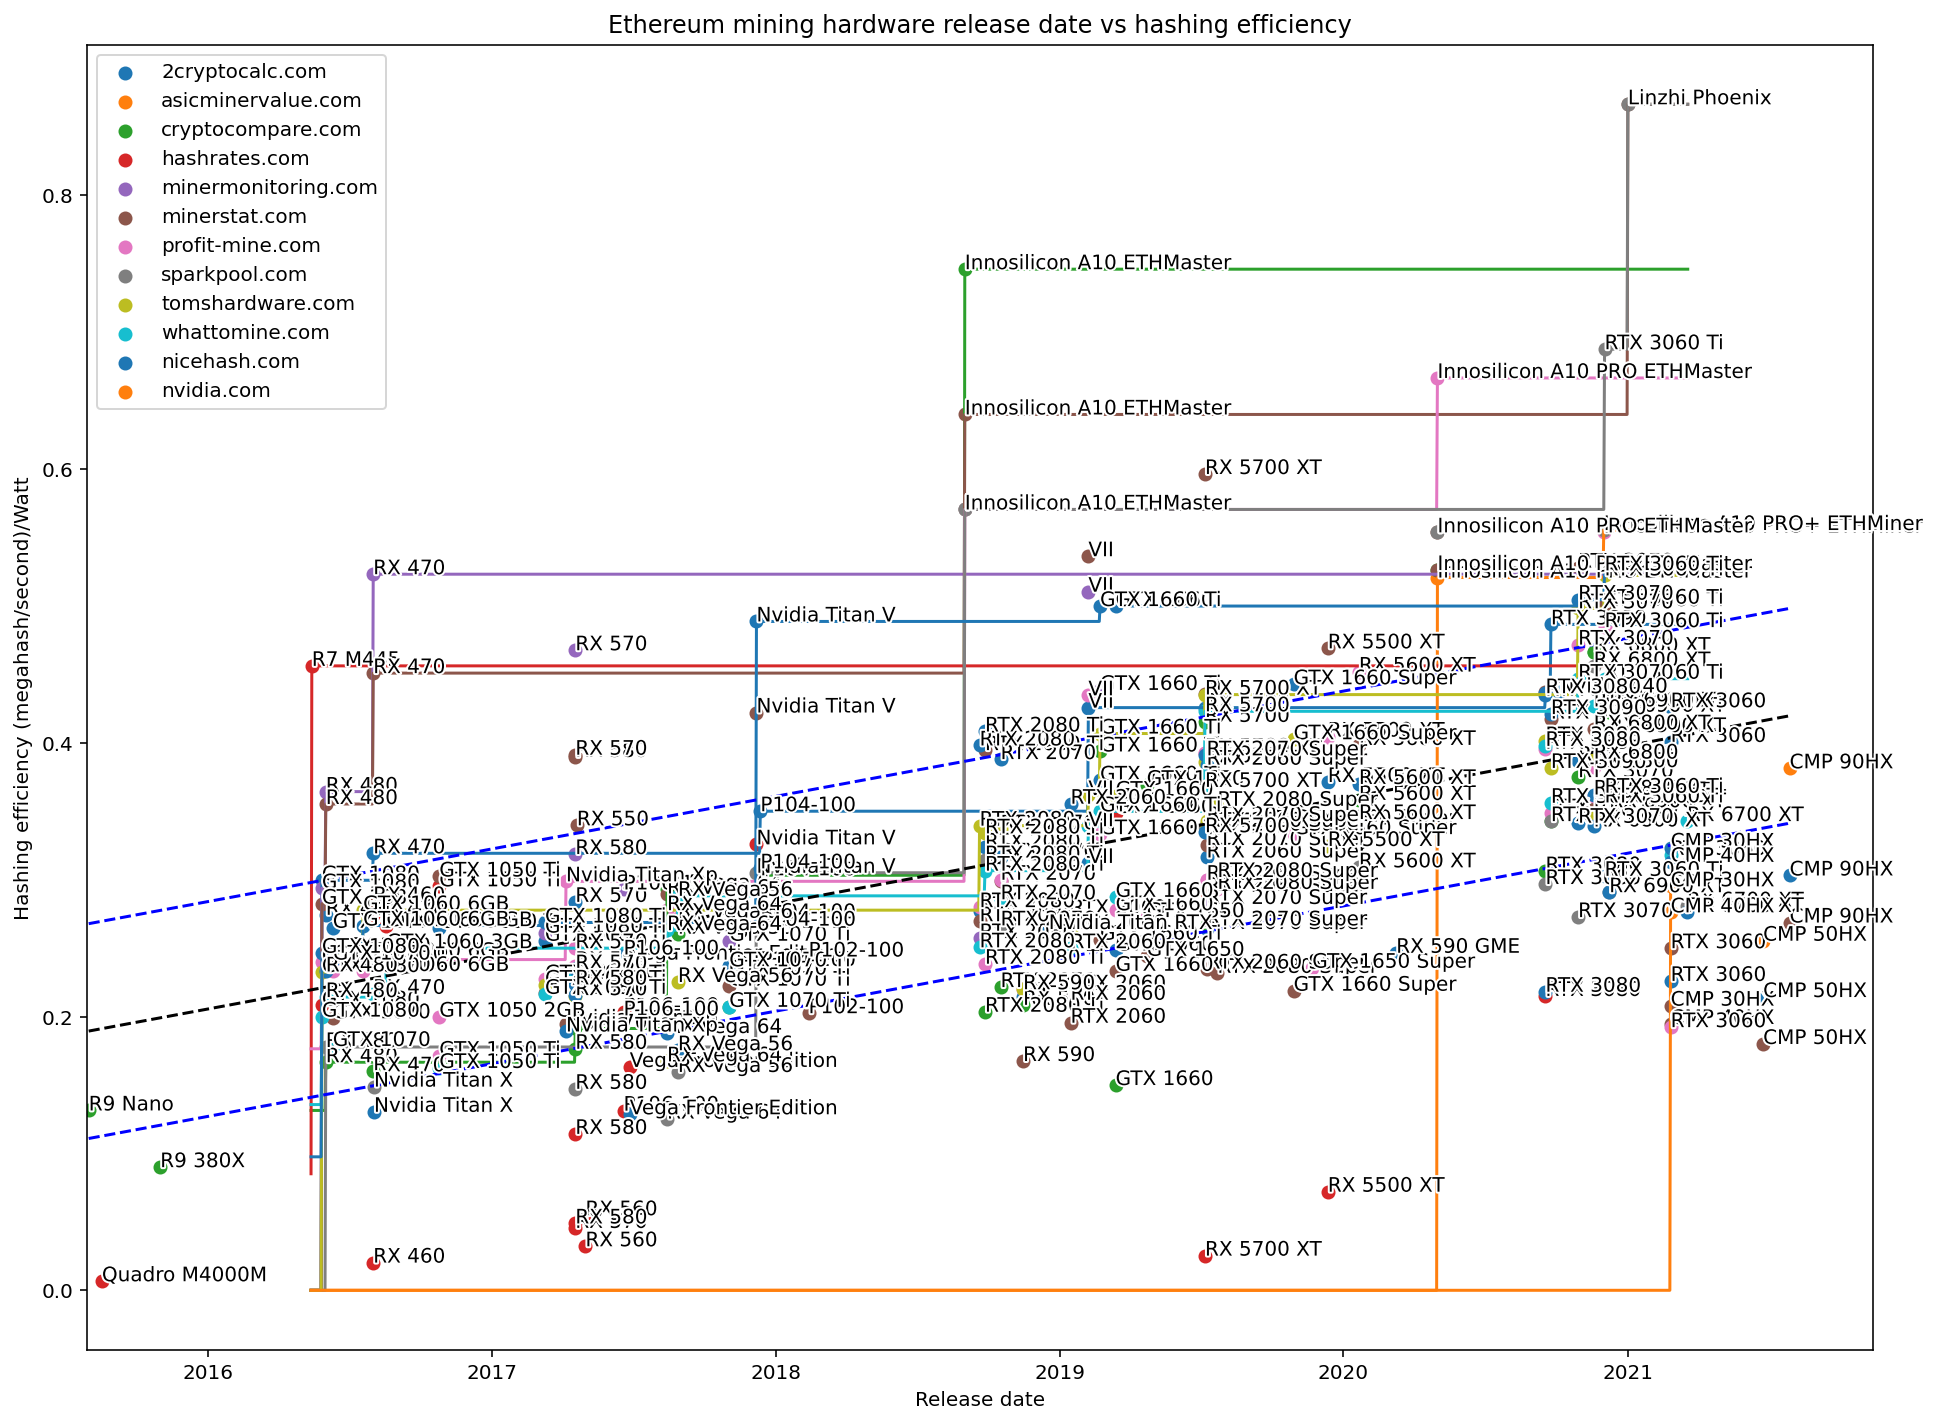

In [7]:
# effects = [path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()]

# plt.figure(figsize=(16,12), facecolor='white')
# plt.title(f'Ethereum mining hardware release date vs hashing efficiency')

# pts = []

# for source, triplets in all_triplets.items():
#     labels, releases, hashrates = zip(*triplets)
#     plt.scatter(releases, hashrates, label=source)
#     dates, max_curve = max_hashrate(releases, hashrates)
#     plt.plot(dates, max_curve)
#     for label, release, hashrate in triplets:
#         if release < start_date or release > end_date:
#             continue
#         label = label.replace('GeForce ', '').replace('Radeon ', '')
#         text = plt.text(release, hashrate, label)
#         text.set_path_effects(effects)
#         pts.append((release, hashrate))

# xs,ys = zip(*pts)
# xs = [date_to_timestamp(e) for e in xs]
# z = np.polyfit(xs, ys, 1)
# p = np.poly1d(z)
# ends = [min(xs), max(xs)]
# # ends = [
# #     datetime.datetime.fromisoformat(str(start_date)).timestamp(),
# #     datetime.datetime.fromisoformat(str(end_date)).timestamp()]
# plt.plot([timestamp_to_date(e) for e in ends], p(ends), 'k--')

# mae = np.mean(np.abs(ys - p(xs)))
# plt.plot([timestamp_to_date(e) for e in ends], p(ends)+mae, 'b--')
# plt.plot([timestamp_to_date(e) for e in ends], p(ends)-mae, 'b--')

# plt.legend()
# plt.xlabel('Release date')
# plt.ylabel('Hashing efficiency (megahash/second)/Watt')
# plt.xlim((start_date, end_date))
# plt.show()